# SSL Baselines on Half-Moon Dataset

In [63]:
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, SpectralEmbedding
from umap import UMAP

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pickle

from MoonsMLP import MoonsMLP

torch.set_printoptions(precision=4)

### Noisy Half-Moons, Partially Labeled

(100, 2)


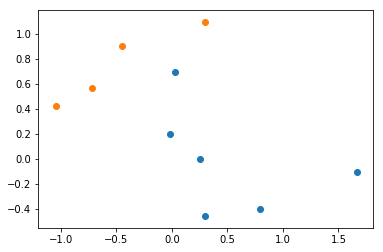

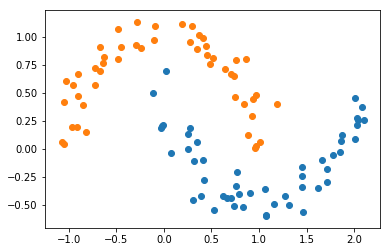

In [68]:
def plot_moons(X, y):
    top = (y == 0)
    bottom = (y == 1)
    plt.scatter(X[bottom,0], X[bottom,1])
    plt.scatter(X[top,0], X[top,1])
    plt.show()
    
n_total = 100
n_labeled = 10
noise = 0.1
X, y = make_moons(n_samples=n_total, noise=noise)
# X = np.random.multivariate_normal(mean=np.array([1,1]), cov=np.array([
#     [1, 0],
#     [0, 100]
# ]), size=X.shape)
print(X.shape)
Xl, yl = X[:n_labeled], y[:n_labeled]
Xu, yu = X[n_labeled:], y[n_labeled:]
plot_moons(Xl, yl)
plot_moons(X, y)

In [12]:
# mean = [10, 10]
# cov = [[1,0.9], [0.9,1]]


# x1, x2 = np.random.multivariate_normal(mean, cov, len(X)).T
# X = np.stack([x1, x2], axis=1)
# y = np.ones_like(y)
# print(X.shape)
# plt.plot(x1, x2, 'x')
# plt.axis('equal')
# plt.show()

### Visualizing 2-D Embeddings

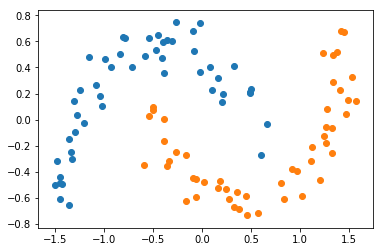

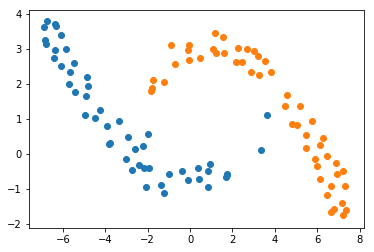

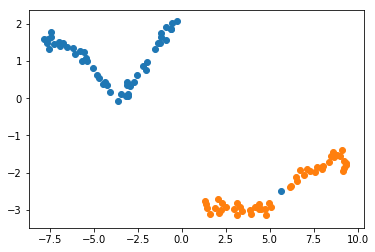

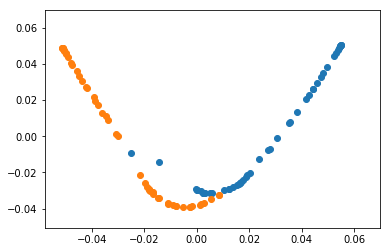

In [69]:
class ZCA:
    def __init__(self, n_components):
        super().__init__()
        self.pca = PCA(n_components=n_components, whiten=False)
        
    def normalize(self, data):
        return data - data.mean(axis=0)
    
    def fit_transform(self, data):
        U, sigma, _ = np.linalg.svd(data)
        print(U.shape, sigma.shape)
        W = U @ np.diag(1/sigma) @ U.T
        return self.normalize(data) @ W
    
embeddings = [
    PCA(n_components=2),
#     ZCA(n_components=2),
    TSNE(n_components=2),
    UMAP(n_components=2),
    SpectralEmbedding(n_components=2)
]
for embedder in embeddings:
    plot_moons(embedder.fit_transform(X), y=y)

### Visualizing UMAP 2-D Embeddings of Train Data, then (Unseen) Test Data in Unsupervised, Semi-Supervised, Fully-Supervised Cases

Unsupervised


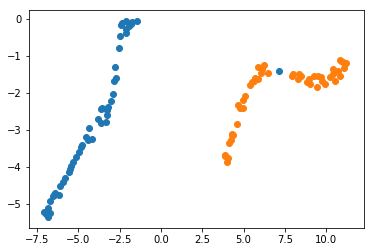

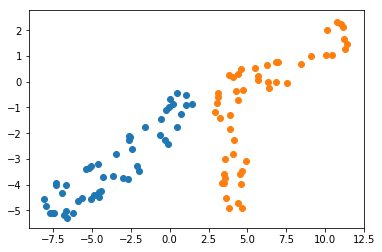

Semisupervised


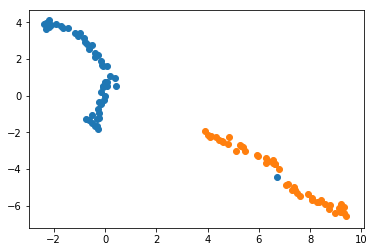

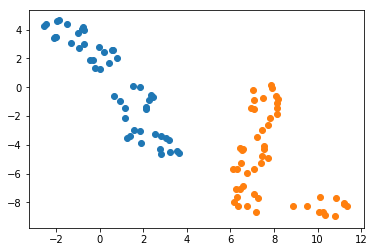

Supervised


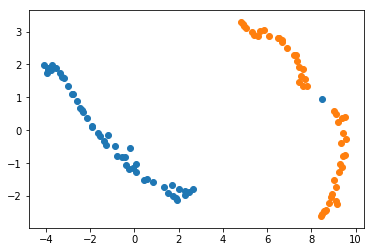

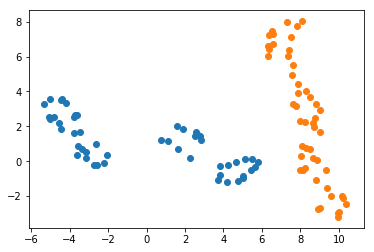

In [70]:
X_val, y_val = make_moons(n_samples=n_total, noise=noise)

# Unsupervised clustering
print("Unsupervised")
umap = UMAP(n_components=2).fit(X)
plot_moons(umap.transform(X), y)
plot_moons(umap.transform(X_val), y_val)
# Semisupervised clustering
print("Semisupervised")
y_masked = y.copy()
y_masked[n_labeled:] = -1
umap = UMAP(n_components=2).fit(X, y_masked)
plot_moons(umap.transform(X), y)
plot_moons(umap.transform(X_val), y_val)
# Supervised clustering
print("Supervised")
umap = UMAP(n_components=2).fit(X)
plot_moons(umap.transform(X), y)
plot_moons(umap.transform(X_val), y_val)

# file = 'umap.pkl'
# with open(file, 'wb') as outfile:
#     pickle.dump(umap, outfile)
    
# with open(file, 'rb') as infile:
#     umap2 = pickle.load(infile)    
    
# X, y = make_moons(n_samples=n_total, noise=0.3)
# plot_moons(umap2.transform(X), y)

In [61]:
def train(X_train, y_train, X_test, y_test, pi_model=False, self_training=False):
    net = MoonsMLP()
    opt = optim.Adam(net.parameters(), lr=0.1)
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train).long()
    X_test = torch.Tensor(X_test)
    y_test = torch.Tensor(y_test).long()
    lmbda = 1 # weight on unsupervised loss
    # Train
    for i in range(100):
        opt.zero_grad()
        yhat = net(X_train)
        objective = nn.CrossEntropyLoss()
        loss = objective(yhat, y_train)
        train_acc = (torch.argmax(yhat, dim=1) == y_train).float().mean().item()

        if pi_model:
            objective = nn.MSELoss()
            Xuhat = X_test + 0.1 * torch.randn_like(X_test)
            yu = net(X_test)
            yuhat = net(Xuhat)
            loss_unsupervised = objective(yu, yuhat)
#             print(((yu - yuhat)**2).mean().item())
#             print(loss_unsupervised.item())
#             print("ls: {}, lu: {}".format(loss, loss_unsupervised))
            loss += lmbda * loss_unsupervised
    
        if self_training:
            y_test_hat = net(X_test)
            best_i = torch.argmax(y_test_hat, keepdim=False)
            best_i = np.unravel_index(best_i, y_test_hat.shape)
            
            x_train = None
            
            print(y_test_hat.shape)
            print(best_i)
            print(y_test_hat[best_i])
#             print(y_test_hat.flatten()[best_i])
            print(y_test_hat.max())
            
            return
                   
            
        loss.backward()
        opt.step()
    # Test
    yhat = net(X_test)
    test_acc = (torch.argmax(yhat, dim=1) == y_test).float().mean().item()
    return train_acc, test_acc
        

print(train(Xl, yl, Xu, yu, self_training=True))

torch.Size([90, 2])
(27, 1)
tensor(-0.2252, grad_fn=<SelectBackward>)
tensor(-0.2252, grad_fn=<MaxBackward1>)
None


### Experimenting with MLP Classification on Various Embeddings
Five trials each, standard deviation is reported.

In [62]:
def preprocess_and_train(X_orig, y, embedder, n_labeled=n_labeled, **kwargs):
    test_accs = []
    for i in range(10):
        if embedder is not None:
            X = embedder.fit_transform(X_orig)
        else:
            X = X_orig

        # Randomly chose the labeled data each time
        indices = np.random.choice(len(X), size=n_labeled, replace=False)
        Xl, yl = X[indices], y[indices]
        Xu, yu = X[~indices], y[~indices]
#         Xl, yl = X[:n_labeled], y[:n_labeled]
#         Xu, yu = X[n_labeled:], y[n_labeled:]

        train_acc, test_acc = train(Xl, yl, Xu, yu, **kwargs)
        test_accs.append(test_acc)
        
    test_acc = np.mean(test_accs)
    test_std = np.std(test_accs)
    embedder_name = str(embedder.__class__).split("'")[1] if embedder else 'None'
    print('{}: test acc {:.3f} +- {:.3f}'.format(embedder_name, test_acc, test_std))
    
preprocess_and_train(X, y, embedder=None)
preprocess_and_train(X, y, embedder=PCA(n_components=2))
preprocess_and_train(X, y, embedder=TSNE(n_components=2))
preprocess_and_train(X, y, embedder=UMAP(n_components=2))
preprocess_and_train(X, y, embedder=SpectralEmbedding(n_components=2))

print("\nPi Model")
preprocess_and_train(X, y, embedder=None, pi_model=True)
preprocess_and_train(X, y, embedder=PCA(n_components=2), pi_model=True)
preprocess_and_train(X, y, embedder=TSNE(n_components=2), pi_model=True)
preprocess_and_train(X, y, embedder=UMAP(n_components=2), pi_model=True)
preprocess_and_train(X, y, embedder=SpectralEmbedding(n_components=2), pi_model=True)



None: test acc 0.710 +- 0.130
sklearn.decomposition.pca.PCA: test acc 0.810 +- 0.158
sklearn.manifold.t_sne.TSNE: test acc 0.870 +- 0.127
umap.umap_.UMAP: test acc 1.000 +- 0.000
sklearn.manifold.spectral_embedding_.SpectralEmbedding: test acc 0.870 +- 0.119

Pi Model
None: test acc 0.810 +- 0.104
sklearn.decomposition.pca.PCA: test acc 0.760 +- 0.120
sklearn.manifold.t_sne.TSNE: test acc 0.850 +- 0.092
umap.umap_.UMAP: test acc 0.980 +- 0.060
sklearn.manifold.spectral_embedding_.SpectralEmbedding: test acc 0.510 +- 0.255
